# 사설 원문 전처리

데이터 불러오기

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel('data/raw_data.xlsx')

#타깃 데이터(찬성, 반대) 비율 체크
print(pd.value_counts(df['Pos'].values, sort=False))

0    330
1    330
dtype: int64


형태소 단위로 토큰화

In [2]:
from konlpy.tag import Okt

df = df[['Content', 'Pos']]

okt = Okt()

for i in range(len(df)):       
    df.loc[i,'Content'] = str(okt.pos(df.loc[i,'Content'], norm=True, stem=True))

명사, 동사, 부사, 형용사만 추출

In [3]:
import ast

tags = ['Noun', 'Verb', 'Adverb', 'Adjective']

for i in range(len(df)):
    pos_list = ast.literal_eval(df.loc[i, 'Content'])
    
    # tags내의 품사(명사, 동사, 부사, 형용사)를 갖는 토큰만 뽑아내기
    final = []
    
    for j in range(len(pos_list)):
        if pos_list[j][1] in tags:
            final.append(pos_list[j][0])
    
    df.loc[i, 'Content'] = str(final)[1:-1]

Train/Test set 분리

In [4]:
from sklearn.model_selection import train_test_split

data = df['Content']
target = df['Pos']

x_train_initial, x_test_initial, y_train_initial, y_test_initial = train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target)

In [5]:
x_train_mid = []

for content in x_train_initial:
    temp = list(map(str.strip, content.replace('\'', '').split(',')))
    x_train_mid.append(temp)

x_test_mid = []

for content in x_test_initial:
    temp = list(map(str.strip, content.replace('\'', '').split(',')))
    x_test_mid.append(temp)

정수 인코딩

In [6]:
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_mid)

#print(tokenizer.word_index)

3회 미만으로 등장하는 토큰 제거

In [8]:
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0 
total_freq = 0 
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt += 1
        rare_freq += value

print('단어 수 ',total_cnt)
print('%s회 이하로 등장하는 단어 수: %s'%(threshold - 1, rare_cnt))
print("전체 토큰 중 희귀 토큰의 비중:", (rare_cnt / total_cnt)*100)
print("전체 빈도수 중 희귀 토큰의 빈도수 비중: ", (rare_freq / total_freq)*100)

단어 수  9745
2회 이하로 등장하는 단어 수: 4566
전체 토큰 중 희귀 토큰의 비중: 46.85479733196511
전체 빈도수 중 희귀 토큰의 빈도수 비중:  3.740401131656058


In [9]:
vocab_size = total_cnt - rare_cnt + 2
print('희귀 단어 제거 후 단어 수: ',vocab_size)

희귀 단어 제거 후 단어 수:  5181


In [10]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(x_train_mid)

x_train = tokenizer.texts_to_sequences(x_train_mid)
x_test = tokenizer.texts_to_sequences(x_test_mid)

y_train = y_train_initial
y_test = y_test_initial

패딩

샘플의 최대 길이:  1200
샘플 평균 길이:  299.90909090909093


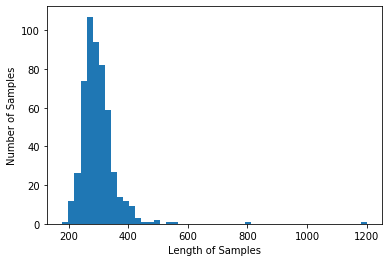

In [11]:
print('샘플의 최대 길이: ',max(len(l) for l in x_train))
print('샘플 평균 길이: ',sum(map(len, x_train))/len(x_train))
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [12]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    
    print('%s보다 짧은 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [13]:
max_len = 500
below_threshold_len(max_len, x_train)

x_train = pad_sequences(x_train, maxlen = max_len)
x_test = pad_sequences(x_test, maxlen = max_len)

500보다 짧은 샘플의 비율: 99.24242424242425


# 모델링 (LSTM 적용)

In [14]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
model = Sequential()
model.add(Embedding(vocab_size, 500))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', 
                     mode='max', verbose=1, save_best_only=True)

In [17]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=15, callbacks=[es, mc],
                    batch_size=60, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 422 samples, validate on 106 samples
Epoch 1/15
420/422 [============================>.] - ETA: 0s - loss: 0.6687 - acc: 0.5857
Epoch 00001: val_acc improved from -inf to 0.56604, saving model to best_model.h5
422/422 [==============================] - 54s 128ms/sample - loss: 0.6815 - acc: 0.5829 - val_loss: 0.6597 - val_acc: 0.5660
Epoch 2/15
420/422 [============================>.] - ETA: 0s - loss: 0.5609 - acc: 0.7524
Epoch 00002: val_acc improved from 0.56604 to 0.72642, saving model to best_model.h5
422/422 [==============================] - 53s 126ms/sample - loss: 0.5622 - acc: 0.7488 - val_loss: 0.5969 - val_acc: 0.7264
Epoch 3/15
420/422 [============================>.] - ETA: 0s - loss: 0.3814 - acc: 0.9286
Epoch 00003: val_acc improved from 0.72642 to 0.73585, saving model to best_model.h5
422/422 [==============================] - 60s 142ms/sample - loss: 0.3811 - acc: 0

In [18]:
loaded_model = load_model('best_model.h5')
print("\nTrain Accuracy: %.4f" % (loaded_model.evaluate(x_train, y_train)[1]))
print("\nTest Accuracy: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
528/528 [==============================] - 13s 25ms/sample - loss: 0.1408 - acc: 0.9602

Train Accuracy: 0.9602
132/132 [==============================] - 3s 24ms/sample - loss: 0.4065 - acc: 0.8636

Test Accuracy: 0.8636
